# Stock Market Section

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
from scipy.stats import norm
import statsmodels.api as sm
from IPython.display import display, HTML, Markdown
import os
import yfinance as yf
import requests
from bs4 import BeautifulSoup

sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="colorblind",
    color_codes=True,
    rc={"figure.figsize": [12, 8]},
)

# Introduction to Stock Market Data
Specifying the ticker and time duration to yfinance API allows us to obtain a data frame of daily data of the stock data we needed. For our analysis we want major stock indecies, including S&P 500 (represented by SPY ETF), NASDAQ, and DOW Jones Industrial Average.Th data frames of SPY, NASDAQ, and DOW JONES we retrieved all shared the same features, including `Date`, `Open`, `High`, `Low`, `Close`, `Volume`, `Dividends`, `Stock Splits`, and `Capital Gains` from **1998** to **2022**

**Date**: It's the trading day for which the data is recorded.

**Open**: The price at which a stock starts trading when the market opens on a given day.

**High**: The highest price at which the stock traded during the trading day.

**Low**: The lowest price at which the stock traded during the trading day.

**Close**: The price of the stock at the closing of the trading day. It measures the performance of the stock on that day.

**Volume**: The total number of shares of the stock traded during the day. High volume can indicate a high interest in the stock on that particular day, either buying or selling.

**Dividends**: The distribution of some of a company's earnings to a class of its shareholders, usually in the form of cash or stock. Not all companies pay dividends.

**Stock Splits**: An action taken by a company to divide its existing shares into multiple shares. Although the number of shares outstanding increases by a specific multiple, the total dollar value of the shares remains the same, so it does not affect the company's market capitalization.

**Capital Gains**: Capital gains represent the profit made from the sale of stocks - the difference between the purchase price and the selling price.  (this feature may not be needed)

For this particular analysis, we are only going to use the `open` and `close` features.

# 1. Data Retrieval:
1. Retrieve stock market data from yahoo finance API library, yfinance
2. Store the data table under 'data' folder

In [3]:
# Retrieve tiackers from yfianance API, SPY, NASDAQ, and Dow Jones
spy = yf.Ticker("SPY")
nasdaq = yf.Ticker("^IXIC")
dow_jones = yf.Ticker("^DJI")

# Set the period
start_date = "1998-01-01"
end_date = "2023-12-31"

# Retrieve historical market data
spy_history = spy.history(start=start_date, end=end_date)
nasdaq_history = nasdaq.history(start=start_date, end=end_date)
dow_jones_history = dow_jones.history(start=start_date, end=end_date)

# Export stock market data to CSV Files
spy_history.to_csv("spy.csv")
nasdaq_history.to_csv("nasdaq.csv")
dow_jones_history.to_csv("dow.csv")

In [4]:
# Uncomment following code if stock data CSV is not stored in data folder
# folder_name = 'data'

# Create the market_data folder
# if not os.path.exists(folder_name):
#    os.mkdir(folder_name)

# Move files to the market_data folder
# os.rename('spy.csv', os.path.join(folder_name, 'spy.csv'))
# os.rename('nasdaq.csv', os.path.join(folder_name, 'nasdaq.csv'))
# os.rename('dow.csv', os.path.join(folder_name, 'dow.csv'))

In [5]:
spy_df = pd.read_csv("data/spy.csv")
nasdaq_df = pd.read_csv("data/nasdaq.csv")
dow_df = pd.read_csv("data/dow.csv")

## Add Market Size Ranking to Baseball Data
We referenced the ranking of market size produced by Nielsen TV: 
https://www.sportsmediawatch.com/nba-market-size-nfl-mlb-nhl-nielsen-ratings/

Web scraped Nielsen TV's baseball market size ranking table. The table contains MLB team names and their respective market size ranking from 1 to 30. Added 'Toronto Blue Jays' into the ranking list because it was not included by Nielsen TV. The MLB team names used by Nielsen doesn't contain city names and uses forms for some names, so I extract the team names from baseball data and match them to the corresponding forms in the Nielsen TV's data table. Then, the market size rankings are mapped to the corresponding teams in the baseball data frame.

In [6]:
# baseball data frame
baseball_df = pd.read_csv("data/baseball.csv")

# Scrape Baseball Team Market Size by Nielsen TV market size:
url = "https://www.sportsmediawatch.com/nba-market-size-nfl-mlb-nhl-nielsen-ratings/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find("table")
dfs = pd.read_html(str(table))
market_df = dfs[0]
market_df = market_df[market_df["MLB"] != "no team"].copy()

# Generate a list of MLB teams ranked from large market to small market according
market_df.loc[:, "MLB"] = market_df["MLB"].str.split(", ")
market_df = market_df.explode("MLB")
market_df = market_df["MLB"].reset_index(drop=True)
market_size_order = market_df.tolist()
market_size_order.insert(10, "Blue Jays")

# Map ranking label to baseball dataframe
team_name_mapping = {
    "Angels": "Los Angeles Angels",
    "D’Backs": "Arizona Diamondbacks",
    "Braves": "Atlanta Braves",
    "Orioles": "Baltimore Orioles",
    "Red Sox": "Boston Red Sox",
    "Cubs": "Chicago Cubs",
    "White Sox": "Chicago White Sox",
    "Reds": "Cincinnati Reds",
    "Guardians": "Cleveland Indians",
    "Rockies": "Colorado Rockies",
    "Tigers": "Detroit Tigers",
    "Marlins": "Miami Marlins",
    "Astros": "Houston Astros",
    "Royals": "Kansas City Royals",
    "Dodgers": "Los Angeles Dodgers",
    "Brewers": "Milwaukee Brewers",
    "Twins": "Minnesota Twins",
    "Mets": "New York Mets",
    "Yankees": "New York Yankees",
    "A’s": "Oakland Athletics",
    "Phillies": "Philadelphia Phillies",
    "Pirates": "Pittsburgh Pirates",
    "Padres": "San Diego Padres",
    "Mariners": "Seattle Mariners",
    "Giants": "San Francisco Giants",
    "Cardinals": "St. Louis Cardinals",
    "Rays": "Tampa Bay Rays",
    "Rangers": "Texas Rangers",
    "Blue Jays": "Toronto Blue Jays",
    "Nationals": "Washington Nationals",
}

market_ranking_dict = {
    team_name_mapping[team]: rank + 1 for rank, team in enumerate(market_size_order)
}
baseball_df["Market_Size_Rank"] = baseball_df["Team Name"].map(market_ranking_dict)
# baseball_df[['Team', 'Market_Size_Rank']].sample(5)

# 2. Data Exploration and Manipulation
## 2.1 Exploration
At this stage, we focus on exploring the features of our stock data and baseball payroll and manipulate them to prepare for the following analysis
1. Explore the stock market data and baseball payroll through summary statistics.
2. Build a function to check for any null value in our dataset.
3. Date columns of all 3 stock data are in 'str' format. We convert them to datetime format for future analysis.

In [7]:
# SPY Summary Stats
spy_summary_stats = spy_df.describe().T
spy_html = spy_summary_stats.to_html()
display(Markdown("# S&P 500 Summary Statistics"))
display(HTML(spy_html))

# S&P 500 Summary Statistics

,count,mean,std,min,25%,50%,75%,max
Open,6541.0,1.621448e+02,1.117673e+02,5.105904e+01,8.309592e+01,1.041187e+02,2.174794e+02,4.768800e+02
High,6541.0,1.631146e+02,1.123706e+02,5.259946e+01,8.365179e+01,1.047051e+02,2.180434e+02,4.775500e+02
Low,6541.0,1.610856e+02,1.111322e+02,5.042034e+01,8.242083e+01,1.034610e+02,2.166199e+02,4.762600e+02
Close,6541.0,1.621573e+02,1.118005e+02,5.117927e+01,8.303253e+01,1.039727e+02,2.173951e+02,4.766900e+02
Volume,6541.0,1.003630e+08,9.257308e+07,1.436600e+06,4.337720e+07,7.568010e+07,1.312782e+08,8.710263e+08
Dividends,6541.0,1.331096e-02,1.175676e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.906000e+00
Stock Splits,6541.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Capital Gains,6541.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [8]:
# Nasdaq Sumamry Stats
nasdaq_summary_stats = nasdaq_df.describe().T
nasdaq_html = nasdaq_summary_stats.to_html()
display(Markdown("# Nasdaq Summary Statistics"))
display(HTML(nasdaq_html))

# Nasdaq Summary Statistics

,count,mean,std,min,25%,50%,75%,max
Open,6541.0,4.756197e+03,3.769887e+03,1.116760e+03,2.134580e+03,2.854100e+03,6.229620e+03,1.612092e+04
High,6541.0,4.790387e+03,3.796093e+03,1.135890e+03,2.150110e+03,2.873590e+03,6.257680e+03,1.621223e+04
Low,6541.0,4.717619e+03,3.741122e+03,1.108490e+03,2.116820e+03,2.829230e+03,6.200450e+03,1.601723e+04
Close,6541.0,4.756096e+03,3.770499e+03,1.114110e+03,2.135430e+03,2.857210e+03,6.233950e+03,1.605744e+04
Volume,6541.0,2.288731e+09,1.225691e+09,2.214300e+08,1.664870e+09,1.933300e+09,2.332930e+09,1.162119e+10
Dividends,6541.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Stock Splits,6541.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [9]:
# Dow Jones Sumamry Stats
dow_summary_stats = dow_df.describe().T
dow_html = dow_summary_stats.to_html()
display(Markdown("# Dow Jones Summary Statistics"))
display(HTML(dow_html))

# Dow Jones Summary Statistics

,count,mean,std,min,25%,50%,75%,max
Open,6541.0,1.645105e+04,8.244764e+03,6.547010e+03,1.043999e+04,1.256638e+04,2.133593e+04,3.770163e+04
High,6541.0,1.654949e+04,8.282134e+03,6.709610e+03,1.050261e+04,1.261191e+04,2.143310e+04,3.777885e+04
Low,6541.0,1.634895e+04,8.205420e+03,6.469950e+03,1.037524e+04,1.248149e+04,2.125683e+04,3.765098e+04
Close,6541.0,1.645436e+04,8.245796e+03,6.547050e+03,1.044111e+04,1.256979e+04,2.132004e+04,3.771010e+04
Volume,6541.0,2.300696e+08,1.172586e+08,8.410000e+06,1.375900e+08,2.239500e+08,2.975900e+08,9.159900e+08
Dividends,6541.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Stock Splits,6541.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [10]:
# Summary statistics of numerical baseball features
base_numerical_features = baseball_df.select_dtypes(include=[np.number])
num_summary_stats = base_numerical_features.Payroll.describe().T
display(num_summary_stats)

count    7.800000e+02
mean     9.820753e+07
std      5.088906e+07
min      8.317000e+06
25%      6.167708e+07
50%      8.851792e+07
75%      1.252995e+08
max      3.342333e+08
Name: Payroll, dtype: float64

In [11]:
# Creates dictionary of DataFrames
dataframes = {"SPY": spy_df, "NASDAQ": nasdaq_df, "DOW": dow_df}


def check_null_values(df_dict):
    """

    Loop over stock data and check for null value.
    """
    for name, df in df_dict.items():
        total_nulls = df.isnull().sum().sum()
        if total_nulls == 0:
            print(f"{name}: No null values")
        else:
            print(f"{name}: {total_nulls} null values")


check_null_values(dataframes)

SPY: No null values
NASDAQ: No null values
DOW: No null values


In [12]:
# Summary statistics of numerical baseball features
base_numerical_features = baseball_df.select_dtypes(include=[np.number])
num_summary_stats = base_numerical_features.Payroll.describe().T
display(num_summary_stats)

count    7.800000e+02
mean     9.820753e+07
std      5.088906e+07
min      8.317000e+06
25%      6.167708e+07
50%      8.851792e+07
75%      1.252995e+08
max      3.342333e+08
Name: Payroll, dtype: float64

In [13]:
# Converting Date columns to datetime format
spy_df["Date"] = pd.to_datetime(spy_df["Date"], utc=True)
nasdaq_df["Date"] = pd.to_datetime(nasdaq_df["Date"], utc=True)
dow_df["Date"] = pd.to_datetime(dow_df["Date"], utc=True)

## 2.2 Data Manipulation 

In addition to the macro-economy condition, we also want to see short-term stock fluctuation have any influence on payroll decisions. Through we describe statistics we can see our stock data is in daily basis. The scale of prices varies between different stock indecies and payroll. Before we start analyzing the relationship, we need to first manipulate both datasets:

1)At first, we would aggregate our daily stock data into annual data to align with our annual baseball team payroll. We are assuming baseball teams decided their payrolls during their winter meetings that ended in early December. To capture the stock market fluctuation before December, we find out stock market short-term return rates, specifically log return for more stable mathematical property. 2)Secondly, we also want to compare the overarching trend between stock fluctuation and payroll change, so we aggregate the 30 MLB team payrolls to find their average annual payroll. To capture the change rate, we calculated the log change rate of the payrolls. 3) Finally, we want to dive deeper into the variation between baseball teams. So, we filter the teams by top 1/3 of large market team and small market team. Methods are described as following:

### 1) Stock market data aggregation and transformation
**Method: Log Return 3, 6, 9 Months Prior to Baseball Payroll**

We are using December 1st as the cut-off point and aggregate the return of each stock index's price over the past 3, 6, or 9 months by **log return**:

Log ReturnT = ln(Pt+1 / Pt)

1. P: Price of the Stock
2. t: time, 
3. PT+1 is the close price at T, PT is the start price at T.

The aggregation and log return calculation is wrapped inside the function, "stock_yearly_data" which returns a new stock data frame that contains yearly log return data across the 3 specified time frames for each index.

### 2) Baseball team payroll aggregation and transformation 

**Method: Aggregate 30 MLB teams and calculate annual average payroll, then transform by log change**

At first we join our baseball data with the data frame returned by "stock_yearly_data" function. Then we aggregate 30 teams' adjusted payroll data (adjusted for inflation) by year and calculate their average. Finally, we transform the average annual payroll to log change rate: 

Log ChangeT = ln(At+1 / At)

1. A:Payroll value
2. T: Year
3. At+1 is the current year, At is the previous year


### 3) Filter teams by market size

Based on the Nielsen TV market size ranking, we filtered our baseball data into two groups, top 1/3 large market and small market teams. We perform the same transformation for both groups to find their payroll annual log change rates.

In [14]:
def stock_yearly_data(df, index_name):
    # Initialize a dictionary to store yearly data
    yearly_data = {}

    # Ensure the Date feature is in datetime format
    df["Date"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)

    for year in range(1998, 2024):
        yearly_data[year] = {}
        for lag in [3, 6, 9, 11]:
            # Calculate start and end dates for each lag
            start_month = 12 - lag

            start_date = pd.Timestamp(f"{year}-{start_month:02d}-01")
            end_date = pd.Timestamp(f"{year}-12-01")

            # Filter the DataFrame between the start and end dates
            lag_df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

            start_price = lag_df.iloc[0]["Open"]
            end_price = lag_df.iloc[-1]["Close"]
            simple_return = round(((end_price - start_price) / start_price) * 100, 2)
            log_return = np.log(end_price / start_price)

            # Store both returns in the dictionary with dynamic keys
            yearly_data[year][f"{index_name}_{lag}_month_simple_return"] = simple_return
            yearly_data[year][f"{index_name}_{lag}_month_log_return"] = log_return

    # Convert the dictionary to a pandas DataFrame
    yearly_df = pd.DataFrame.from_dict(yearly_data, orient="index")
    yearly_df.index.name = "Year"

    return yearly_df.reset_index()


spy_yearly_data = stock_yearly_data(spy_df, "SPY")
nasdaq_yearly_data = stock_yearly_data(nasdaq_df, "NASDAQ")
dow_yearly_data = stock_yearly_data(dow_df, "DOW")

# Merge stock yearly data
stock_yearly_data = pd.merge(spy_yearly_data, nasdaq_yearly_data, on="Year")
stock_yearly_data = pd.merge(stock_yearly_data, dow_yearly_data, on="Year")

In [15]:
# Join stock market with baseballpayroll
baseball_payroll_df = baseball_df[
    ["Season", "Team", "ADJ_PAYROLL", "Market_Size_Rank"]
].rename(columns={"ADJ_PAYROLL": "adjusted_payroll"})
stock_base_df = pd.merge(
    baseball_payroll_df, stock_yearly_data, left_on="Season", right_on="Year"
)
stock_base_df = stock_base_df[
    [
        "Year",
        "Team",
        "Market_Size_Rank",
        "adjusted_payroll",
        "SPY_3_month_log_return",
        "SPY_6_month_log_return",
        "SPY_9_month_log_return",
        "SPY_11_month_log_return",
        "NASDAQ_3_month_log_return",
        "NASDAQ_6_month_log_return",
        "NASDAQ_9_month_log_return",
        "NASDAQ_11_month_log_return",
        "DOW_3_month_log_return",
        "DOW_6_month_log_return",
        "DOW_9_month_log_return",
        "DOW_11_month_log_return",
    ]
]

# Groupby year and aggregate the stock index annual mean and payroll columns
grouped_df = (
    stock_base_df.groupby("Year")
    .agg(
        {
            "adjusted_payroll": "mean",
            "SPY_3_month_log_return": "mean",
            "NASDAQ_3_month_log_return": "mean",
            "DOW_3_month_log_return": "mean",
            "SPY_6_month_log_return": "mean",
            "NASDAQ_6_month_log_return": "mean",
            "DOW_6_month_log_return": "mean",
            "SPY_9_month_log_return": "mean",
            "NASDAQ_9_month_log_return": "mean",
            "DOW_9_month_log_return": "mean",
            "SPY_11_month_log_return": "mean",
            "NASDAQ_11_month_log_return": "mean",
            "DOW_11_month_log_return": "mean",
        }
    )
    .reset_index()
)


grouped_df["Payroll_Log_Change"] = np.log(
    grouped_df["adjusted_payroll"] / grouped_df["adjusted_payroll"].shift(1)
)

stock_base_grouped_df = grouped_df.dropna()

In [16]:
# Grouped Teams by top 1/3 of Large Market Teams
large_market = stock_base_df[stock_base_df["Market_Size_Rank"] <= 10]
grouped_large_market = (
    large_market.groupby("Year")
    .agg(
        {
            "adjusted_payroll": "mean",
            "SPY_3_month_log_return": "mean",
            "NASDAQ_3_month_log_return": "mean",
            "DOW_3_month_log_return": "mean",
            "SPY_6_month_log_return": "mean",
            "NASDAQ_6_month_log_return": "mean",
            "DOW_6_month_log_return": "mean",
            "SPY_9_month_log_return": "mean",
            "NASDAQ_9_month_log_return": "mean",
            "DOW_9_month_log_return": "mean",
            "SPY_11_month_log_return": "mean",
            "NASDAQ_11_month_log_return": "mean",
            "DOW_11_month_log_return": "mean",
        }
    )
    .reset_index()
)

# log change of payroll
grouped_large_market["Payroll_Log_Change"] = np.log(
    grouped_large_market["adjusted_payroll"]
    / grouped_large_market["adjusted_payroll"].shift(1)
)
grouped_large_market = grouped_large_market.dropna()

In [17]:
# Grouped Teams by bottom 1/3 of Small Market Teams
small_market = stock_base_df[stock_base_df["Market_Size_Rank"] > 20]
grouped_small_market = (
    small_market.groupby("Year")
    .agg(
        {
            "adjusted_payroll": "mean",
            "SPY_3_month_log_return": "mean",
            "NASDAQ_3_month_log_return": "mean",
            "DOW_3_month_log_return": "mean",
            "SPY_6_month_log_return": "mean",
            "NASDAQ_6_month_log_return": "mean",
            "DOW_6_month_log_return": "mean",
            "SPY_9_month_log_return": "mean",
            "NASDAQ_9_month_log_return": "mean",
            "DOW_9_month_log_return": "mean",
            "SPY_11_month_log_return": "mean",
            "NASDAQ_11_month_log_return": "mean",
            "DOW_11_month_log_return": "mean",
        }
    )
    .reset_index()
)
# log change of payroll
grouped_small_market["Payroll_Log_Change"] = np.log(
    grouped_small_market["adjusted_payroll"]
    / grouped_small_market["adjusted_payroll"].shift(1)
)
grouped_small_market = grouped_small_market.dropna()

# 3. Analysis
## Visual Analysis
1. Boxplot
   
    It gives us a quick overview of how payroll data is distributed. It also shows the general trend of the payroll data, as well as outliers.

2. Scatter Plots:

    Three separate linear regression plots are generated to visualize the relationship between the 3,6, and 9 month log returns of SPY, NASDAQ, and DOW indices and the annual payroll log changes. These plots aim to identify any linear correlations between the stock market returns and payroll changes. Each plot likely includes a regression line with a shaded area representing the confidence interval for that line, helping to understand how closely these variables are related. 

3. Line Graph Comparison:

    A line graph compares the trends of 3, 6, and 9 month log returns for SPY, NASDAQ, and DOW against the payroll log change over time. This graph is designed to show how the stock returns of these indices and payroll changes evolve year by year. The payroll log change is highlighted with a distinct coral color, dashed linestyle, and marker options to differentiate it from the stock return lines. The shaded grey areas over specific years illustrate periods where the baseball payrolls change rates seem to follow the trend of stock market change.

**To keep things simple, we only visualize the 6 month stock log returns vs baseball payroll on both scatter and line plots, becasue the 6 months showed most significant p-value in the subsequent linear regression test.** 

## Linear Regression
The analysis explores the relationship between stock market performance, as represented by 3, 6, and 9 month log returns of SPY, NASDAQ, and DOW indices, and payroll log changes across different market sizes using linear regression models. Linear regression model is fitted with 3 payroll groups, all Teams, large Market teams, and Small Markets teams.

In the average market analysis, the objective is to establish a baseline understanding of the general correlation between stock performance and payroll changes across the entire dataset. The large market analysis delves into the dynamics within more significant economic entities or regions, aiming to uncover how larger markets might exhibit unique behaviors in the relationship between stock returns and payroll changes. Conversely, the small market analysis focuses on smaller economic entities or regions, investigating how these markets might respond differently to similar economic indicators. 

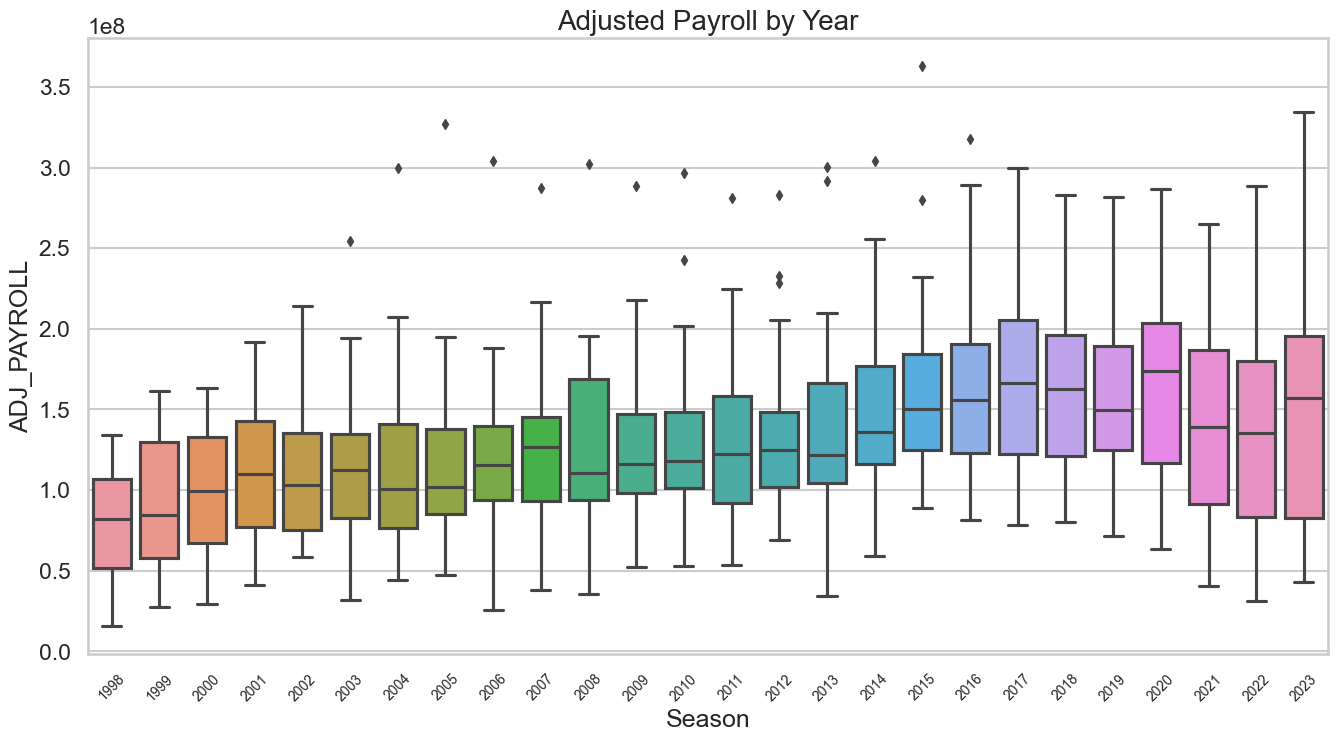

In [18]:
plt.figure(figsize=(16, 8))
sns.boxplot(x="Season", y="ADJ_PAYROLL", data=baseball_df)
plt.title("Adjusted Payroll by Year", fontsize=20)
plt.xticks(rotation=45, fontsize=10)
plt.show()

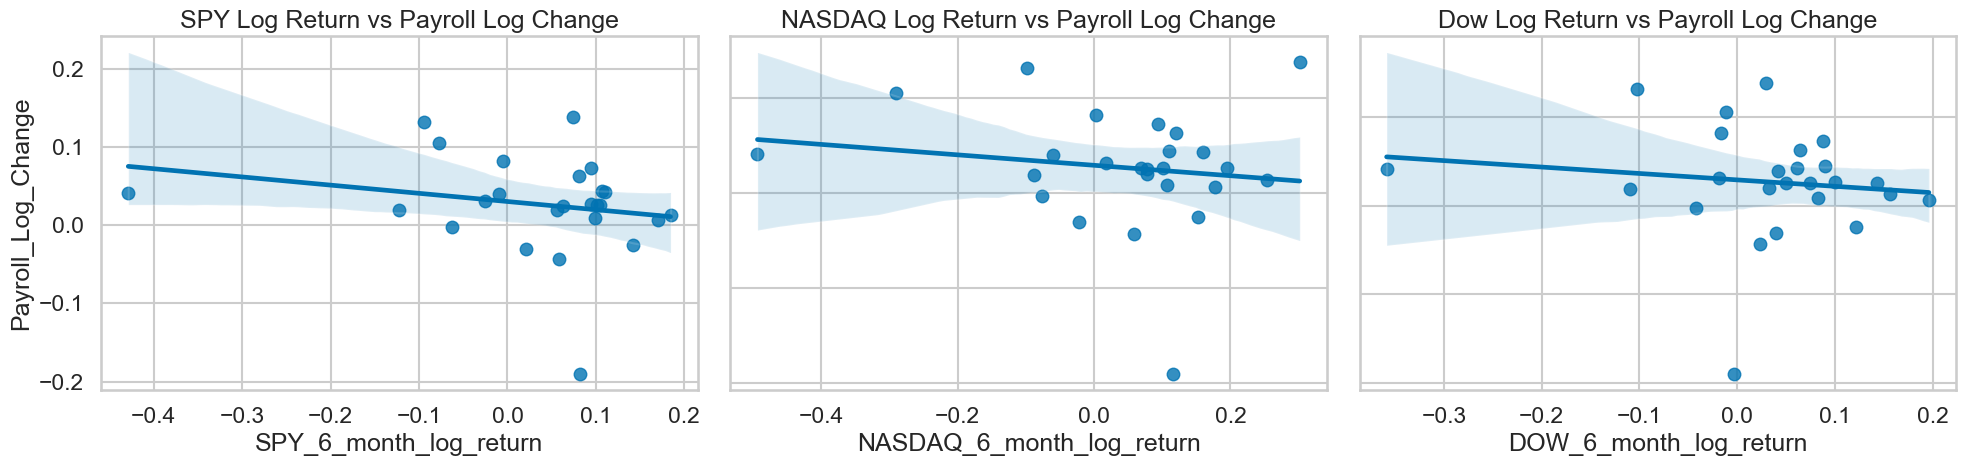

In [19]:
def plot_stock_vs_payroll(dataframe, filename=None):
    """
    Create scatter plots to compare 6 month stock market log return with Payroll log change
    input: dataframe contains stock market log return and payroll log change
    """

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # SPY vs Payroll
    sns.regplot(
        ax=axes[0], x="SPY_6_month_log_return", y="Payroll_Log_Change", data=dataframe
    )
    axes[0].set_title("SPY Log Return vs Payroll Log Change")
    axes[0].tick_params(left=False)

    # NASDAQ vs Payroll
    sns.regplot(
        ax=axes[1],
        x="NASDAQ_6_month_log_return",
        y="Payroll_Log_Change",
        data=dataframe,
    )
    axes[1].set_title("NASDAQ Log Return vs Payroll Log Change")
    axes[1].set_ylabel("")
    axes[1].set_yticklabels([])
    axes[1].tick_params(left=False)

    # Dow vs Payroll
    sns.regplot(
        ax=axes[2], x="DOW_6_month_log_return", y="Payroll_Log_Change", data=dataframe
    )
    axes[2].set_title("Dow Log Return vs Payroll Log Change")
    axes[2].set_ylabel("")
    axes[2].set_yticklabels([])
    axes[2].tick_params(left=False)

    # Adjust layout
    plt.tight_layout()

    # Save plot
    if filename:
        plt.savefig(filename, dpi=300)

    # Show plot
    plt.show()


# Team Average
plot_stock_vs_payroll(stock_base_grouped_df)

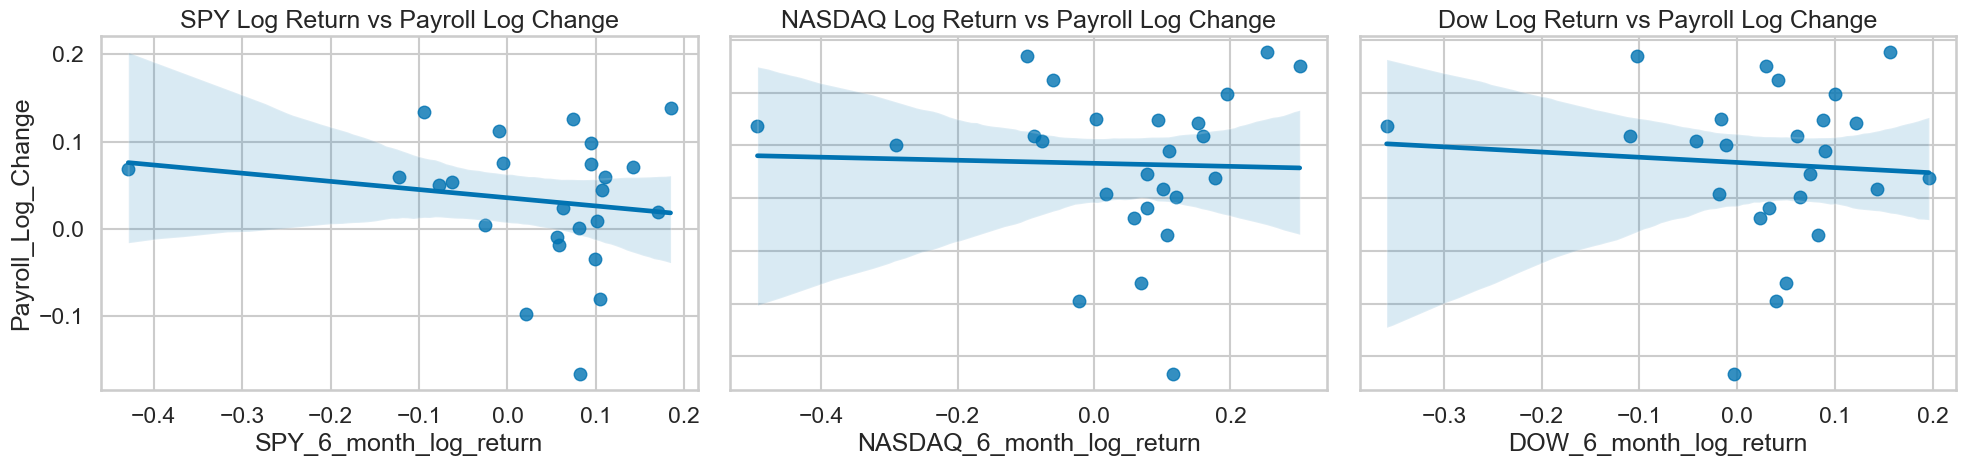

In [20]:
# Large Market
plot_stock_vs_payroll(grouped_large_market, "large_market_Scatter")

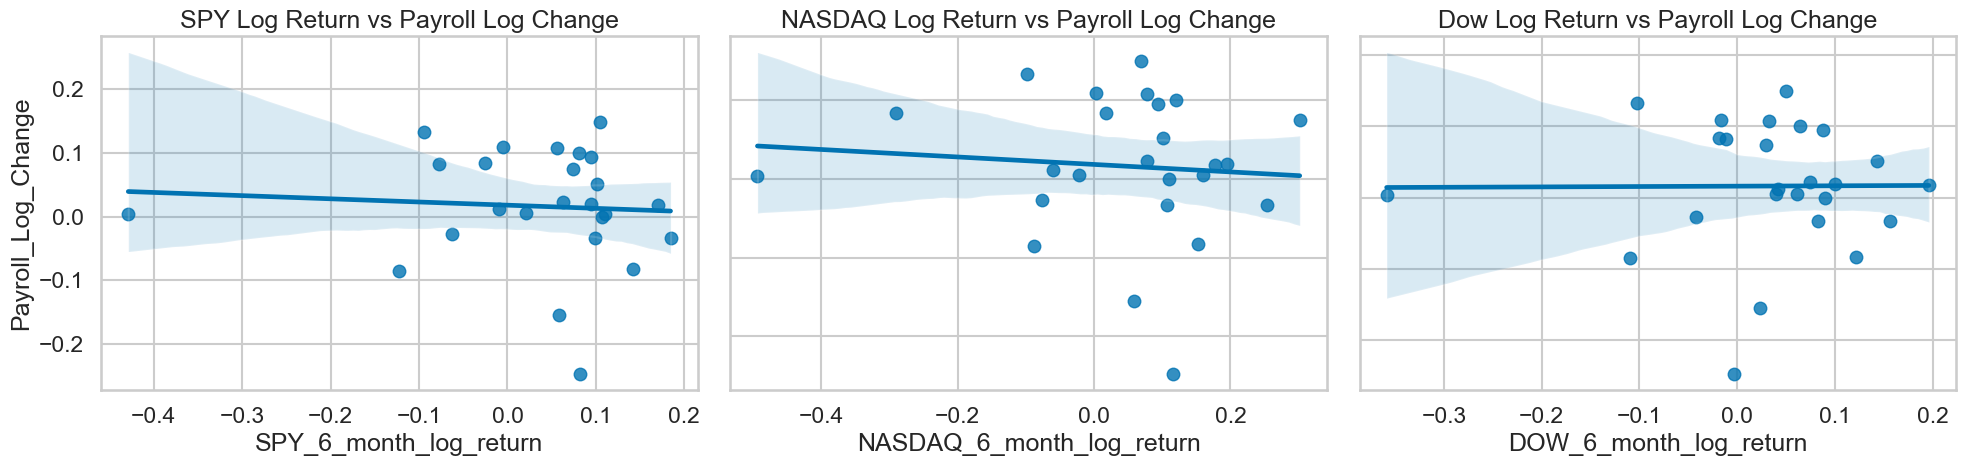

In [21]:
# Small Market
plot_stock_vs_payroll(grouped_small_market)

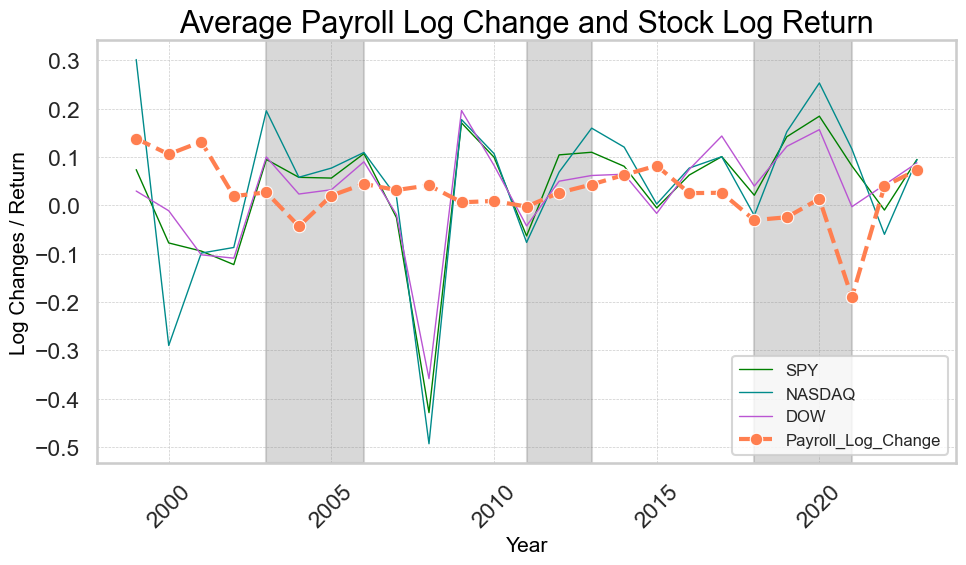

In [22]:
# Plot line graph to compare the trend of market stock return vs payroll log change
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=stock_base_grouped_df,
    x="Year",
    y="SPY_6_month_log_return",
    label="SPY",
    color="green",
    lw=1,
)
sns.lineplot(
    data=stock_base_grouped_df,
    x="Year",
    y="NASDAQ_6_month_log_return",
    label="NASDAQ",
    color="darkcyan",
    lw=1,
)
sns.lineplot(
    data=stock_base_grouped_df,
    x="Year",
    y="DOW_6_month_log_return",
    label="DOW",
    color="mediumorchid",
    lw=1,
)

# Plot baseball payroll log change
sns.lineplot(
    data=stock_base_grouped_df,
    x="Year",
    y="Payroll_Log_Change",
    label="Payroll_Log_Change",
    color="coral",
    lw=3,
    linestyle="--",
    marker="o",
)

plt.title("Average Payroll Log Change and Stock Log Return", fontsize=22, color="black")
plt.xlabel("Year", fontsize=15, color="black")
plt.ylabel("Log Changes / Return", fontsize=15, color="black")
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Place the legend outside the chart, on the right top side
plt.legend(loc="lower right", fontsize=12)

plt.axvspan(2003, 2006, color="grey", alpha=0.3)
plt.axvspan(2011, 2013, color="grey", alpha=0.3)
plt.axvspan(2018, 2021, color="grey", alpha=0.3)

plt.tight_layout()
plt.savefig("Average_Market")
plt.show()

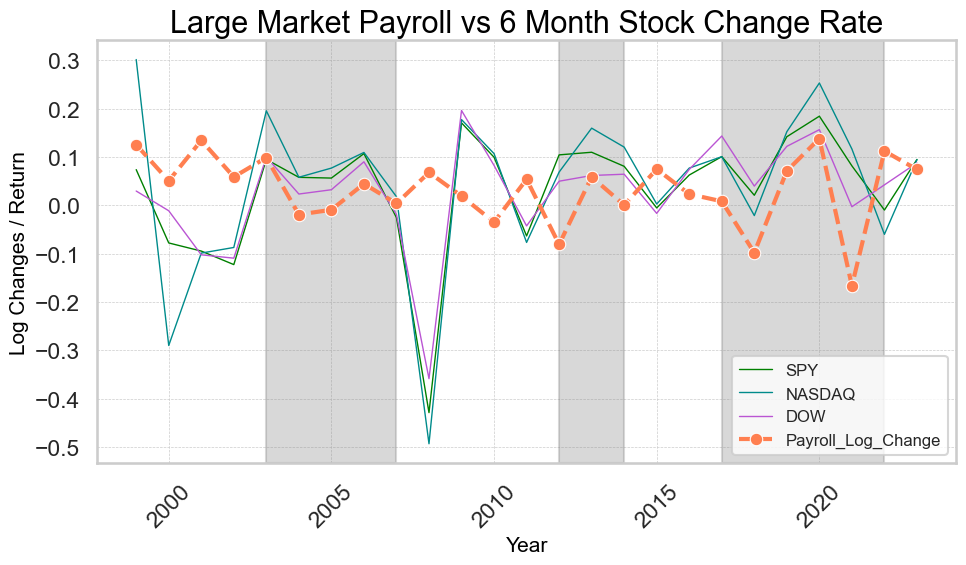

In [23]:
# Plot line graph to compare the trend of stock return vs large market team payroll log change
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=grouped_large_market,
    x="Year",
    y="SPY_6_month_log_return",
    label="SPY",
    color="green",
    lw=1,
)
sns.lineplot(
    data=grouped_large_market,
    x="Year",
    y="NASDAQ_6_month_log_return",
    label="NASDAQ",
    color="darkcyan",
    lw=1,
)
sns.lineplot(
    data=grouped_large_market,
    x="Year",
    y="DOW_6_month_log_return",
    label="DOW",
    color="mediumorchid",
    lw=1,
)

# Plot baseball payroll log change
sns.lineplot(
    data=grouped_large_market,
    x="Year",
    y="Payroll_Log_Change",
    label="Payroll_Log_Change",
    color="coral",
    lw=3,
    linestyle="--",
    marker="o",
)

plt.title(
    "Large Market Payroll vs 6 Month Stock Change Rate", fontsize=22, color="black"
)
plt.xlabel("Year", fontsize=15, color="black")
plt.ylabel("Log Changes / Return", fontsize=15, color="black")
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Place the legend outside the chart, on the right top side
plt.legend(loc="lower right", fontsize=12)

plt.axvspan(2003, 2007, color="grey", alpha=0.3)
plt.axvspan(2012, 2014, color="grey", alpha=0.3)
plt.axvspan(2017, 2022, color="grey", alpha=0.3)

plt.tight_layout()
plt.savefig("Large_Market")
plt.show()

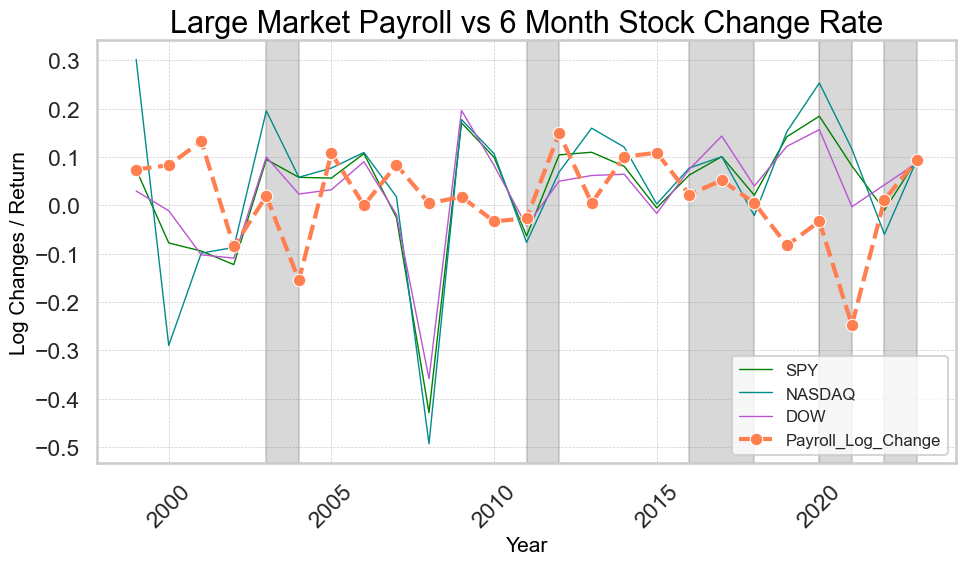

In [24]:
# Plot line graph to compare the trend of stock return vs small market team payroll log change
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=grouped_small_market,
    x="Year",
    y="SPY_6_month_log_return",
    label="SPY",
    color="green",
    lw=1,
)
sns.lineplot(
    data=grouped_small_market,
    x="Year",
    y="NASDAQ_6_month_log_return",
    label="NASDAQ",
    color="darkcyan",
    lw=1,
)
sns.lineplot(
    data=grouped_small_market,
    x="Year",
    y="DOW_6_month_log_return",
    label="DOW",
    color="mediumorchid",
    lw=1,
)

# Plot baseball payroll log change
sns.lineplot(
    data=grouped_small_market,
    x="Year",
    y="Payroll_Log_Change",
    label="Payroll_Log_Change",
    color="coral",
    lw=3,
    linestyle="--",
    marker="o",
)

plt.title(
    "Large Market Payroll vs 6 Month Stock Change Rate", fontsize=22, color="black"
)
plt.xlabel("Year", fontsize=15, color="black")
plt.ylabel("Log Changes / Return", fontsize=15, color="black")
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Place the legend outside the chart, on the right top side
plt.legend(loc="lower right", fontsize=12)

plt.axvspan(2003, 2004, color="grey", alpha=0.3)
plt.axvspan(2011, 2012, color="grey", alpha=0.3)
plt.axvspan(2016, 2018, color="grey", alpha=0.3)
plt.axvspan(2020, 2021, color="grey", alpha=0.3)
plt.axvspan(2022, 2023, color="grey", alpha=0.3)

plt.tight_layout()
plt.savefig("Small_Market")
plt.show()

In [25]:
# Simple Linear Regression between Stock Log Return and 30 Team Average Payroll Log Change
X = stock_base_grouped_df[
    ["SPY_9_month_log_return", "NASDAQ_9_month_log_return", "DOW_9_month_log_return"]
]
y = stock_base_grouped_df["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1.729
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.192
Time:                        11:45:44   Log-Likelihood:                 36.692
No. Observations:                  25   AIC:                            -65.38
Df Residuals:                      21   BIC:                            -60.51
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0326      0.014      2.402      0.026       0.004       0.061
SPY_9_month_log_return       -0.7959      0.377     -2.112      0.047      -1.580      -0.012
NASDAQ_9_month_log_return     0.0537      0.098      0.547      0.590      -0.150       0.258
DOW_9_month_log_return        0.7819      0.382      2.046      0.053      -0.013       1.577
==============================================================================
Omnibus:                        6.724   Durbin-Watson:                   1.418
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                4.824
Skew:                          -0.768   Prob(JB):                       0.0896
Kurtosis:                       4.507   Cond. No.                         43.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
X = stock_base_grouped_df[
    ["SPY_6_month_log_return", "NASDAQ_6_month_log_return", "DOW_6_month_log_return"]
]
y = stock_base_grouped_df["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1.480
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.249
Time:                        11:45:44   Log-Likelihood:                 36.331
No. Observations:                  25   AIC:                            -64.66
Df Residuals:                      21   BIC:                            -59.79
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0279      0.013      2.174      0.041       0.001       0.055
SPY_6_month_log_return       -1.0913      0.552     -1.976      0.061      -2.240       0.057
NASDAQ_6_month_log_return     0.2684      0.209      1.285      0.213      -0.166       0.703
DOW_6_month_log_return        0.7907      0.453      1.744      0.096      -0.152       1.734
==============================================================================
Omnibus:                        2.098   Durbin-Watson:                   1.212
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                0.834
Skew:                          -0.328   Prob(JB):                        0.659
Kurtosis:                       3.608   Cond. No.                         57.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
X = stock_base_grouped_df[
    ["SPY_3_month_log_return", "NASDAQ_3_month_log_return", "DOW_3_month_log_return"]
]
y = stock_base_grouped_df["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                 -0.067
Method:                 Least Squares   F-statistic:                    0.4975
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.688
Time:                        11:45:44   Log-Likelihood:                 34.791
No. Observations:                  25   AIC:                            -61.58
Df Residuals:                      21   BIC:                            -56.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0232      0.014      1.615      0.121      -0.007       0.053
SPY_3_month_log_return       -0.8864      0.819     -1.083      0.291      -2.589       0.816
NASDAQ_3_month_log_return     0.1364      0.233      0.586      0.564      -0.348       0.621
DOW_3_month_log_return        0.8153      0.731      1.115      0.277      -0.705       2.336
==============================================================================
Omnibus:                        6.612   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.151
Skew:                          -0.471   Prob(JB):                       0.0462
Kurtosis:                       5.240   Cond. No.                         83.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# Simple Linear Regression between Stock Log Return and Large Market Average Payroll Log Change
X = grouped_large_market[
    ["SPY_9_month_log_return", "NASDAQ_9_month_log_return", "DOW_9_month_log_return"]
]
y = grouped_large_market["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     1.978
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.148
Time:                        11:45:44   Log-Likelihood:                 33.309
No. Observations:                  25   AIC:                            -58.62
Df Residuals:                      21   BIC:                            -53.74
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0390      0.016      2.510      0.020       0.007       0.071
SPY_9_month_log_return       -1.0431      0.431     -2.417      0.025      -1.940      -0.146
NASDAQ_9_month_log_return     0.1718      0.112      1.530      0.141      -0.062       0.405
DOW_9_month_log_return        0.9217      0.438      2.107      0.047       0.012       1.832
==============================================================================
Omnibus:                        0.779   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.575
Skew:                          -0.353   Prob(JB):                        0.750
Kurtosis:                       2.771   Cond. No.                         43.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
X = grouped_large_market[
    ["SPY_6_month_log_return", "NASDAQ_6_month_log_return", "DOW_6_month_log_return"]
]
y = grouped_large_market["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     3.198
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0444
Time:                        11:45:44   Log-Likelihood:                 34.900
No. Observations:                  25   AIC:                            -61.80
Df Residuals:                      21   BIC:                            -56.93
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0313      0.014      2.300      0.032       0.003       0.060
SPY_6_month_log_return       -1.7890      0.585     -3.060      0.006      -3.005      -0.573
NASDAQ_6_month_log_return     0.5591      0.221      2.528      0.020       0.099       1.019
DOW_6_month_log_return        1.2149      0.480      2.531      0.019       0.217       2.213
==============================================================================
Omnibus:                        0.138   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.933   Jarque-Bera (JB):                0.264
Skew:                          -0.152   Prob(JB):                        0.876
Kurtosis:                       2.598   Cond. No.                         57.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
X = grouped_large_market[
    ["SPY_3_month_log_return", "NASDAQ_3_month_log_return", "DOW_3_month_log_return"]
]
y = grouped_large_market["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.086
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.377
Time:                        11:45:44   Log-Likelihood:                 32.000
No. Observations:                  25   AIC:                            -56.00
Df Residuals:                      21   BIC:                            -51.12
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0254      0.016      1.582      0.129      -0.008       0.059
SPY_3_month_log_return       -1.6282      0.916     -1.778      0.090      -3.532       0.276
NASDAQ_3_month_log_return     0.3695      0.260      1.419      0.170      -0.172       0.911
DOW_3_month_log_return        1.4201      0.817      1.737      0.097      -0.280       3.120
==============================================================================
Omnibus:                        0.616   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.735   Jarque-Bera (JB):                0.581
Skew:                          -0.325   Prob(JB):                        0.748
Kurtosis:                       2.634   Cond. No.                         83.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# Simple Linear Regression between Stock Log Return and Small Market Average Payroll Log Change
X = grouped_small_market[
    ["SPY_9_month_log_return", "NASDAQ_9_month_log_return", "DOW_9_month_log_return"]
]
y = grouped_small_market["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                 -0.085
Method:                 Least Squares   F-statistic:                    0.3728
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.773
Time:                        11:45:44   Log-Likelihood:                 25.424
No. Observations:                  25   AIC:                            -42.85
Df Residuals:                      21   BIC:                            -37.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0178      0.021      0.836      0.413      -0.026       0.062
SPY_9_month_log_return       -0.5493      0.591     -0.929      0.364      -1.779       0.681
NASDAQ_9_month_log_return     0.0128      0.154      0.083      0.934      -0.307       0.333
DOW_9_month_log_return        0.6075      0.600      1.013      0.323      -0.640       1.855
==============================================================================
Omnibus:                        2.255   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.114
Skew:                          -0.487   Prob(JB):                        0.573
Kurtosis:                       3.348   Cond. No.                         43.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
X = grouped_small_market[
    ["SPY_6_month_log_return", "NASDAQ_6_month_log_return", "DOW_6_month_log_return"]
]
y = grouped_small_market["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                    0.5371
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.662
Time:                        11:45:44   Log-Likelihood:                 25.699
No. Observations:                  25   AIC:                            -43.40
Df Residuals:                      21   BIC:                            -38.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0158      0.020      0.804      0.430      -0.025       0.057
SPY_6_month_log_return       -0.8512      0.845     -1.007      0.325      -2.608       0.906
NASDAQ_6_month_log_return     0.0915      0.320      0.286      0.777      -0.573       0.756
DOW_6_month_log_return        0.8279      0.694      1.194      0.246      -0.615       2.270
==============================================================================
Omnibus:                        0.217   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.124
Skew:                          -0.146   Prob(JB):                        0.940
Kurtosis:                       2.815   Cond. No.                         57.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
X = grouped_small_market[
    ["SPY_3_month_log_return", "NASDAQ_3_month_log_return", "DOW_3_month_log_return"]
]
y = grouped_small_market["Payroll_Log_Change"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Payroll_Log_Change   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                    0.5500
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.654
Time:                        11:45:44   Log-Likelihood:                 25.721
No. Observations:                  25   AIC:                            -43.44
Df Residuals:                      21   BIC:                            -38.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0092      0.021      0.444      0.662      -0.034       0.052
SPY_3_month_log_return       -0.9140      1.177     -0.777      0.446      -3.362       1.534
NASDAQ_3_month_log_return     0.0199      0.335      0.059      0.953      -0.676       0.716
DOW_3_month_log_return        1.0592      1.051      1.008      0.325      -1.126       3.245
==============================================================================
Omnibus:                        0.766   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.682   Jarque-Bera (JB):                0.326
Skew:                          -0.280   Prob(JB):                        0.850
Kurtosis:                       3.002   Cond. No.                         83.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
%load_ext watermark
%watermark -d -t -v -p pandas,numpy,matplotlib,seaborn,pandas_datareader,scipy,statsmodels,yfinance,requests

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.5.0

pandas           : 1.5.3
numpy            : 1.24.2
matplotlib       : 3.7.1
seaborn          : 0.12.2
pandas_datareader: 0.10.0
scipy            : 1.10.1
statsmodels      : 0.14.1
yfinance         : 0.2.35
requests         : 2.31.0

